# **Classification of gastrointestinal abnormalities by endoscopic imaging with deep learning**


In this study we used endoscopic imaging of the human gastrointestinal tract to detect different types of abnormalities. We used the `KVASIR` dataset for this task along with a convolutional neural network.

The `KVASIR` dataset consists of 4000 annotated images of the gastrointestinal tract in 8 different classes (different anomalies), each class has 500 images.

The 8 classes of anomalies:
- dyed-lifted-polyps
- normal-cecum
- normal-pylorus
- normal-z-line
- esophagitis
- polyps
- ulcerative colitis
- dyed-resection-margins

## **Required Libraries**
Here we import all the required libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to split the data into random training and testing subsets.
from sklearn.model_selection import train_test_split

# to calculate the confusion matrix
from sklearn.metrics import confusion_matrix

# to reduce the learning rate when a metric has stopped improving.
from keras.callbacks import ReduceLROnPlateau

# to be able to import use the pre-train VGG19 model
from tensorflow.keras.applications import VGG19

# to convert class vector (y) (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

# to generate altered images
from keras.preprocessing.image import ImageDataGenerator

# to initialize the desente gradient method
from tensorflow.keras.optimizers import SGD, Adam

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

#### **Request to delete saved model**:
As learning takes time, the model has been saved, it can be deleted to resume learning the model at 0.

If the deletion request is answered by:
- between `Y`: to delete the model
- any character: do not delete

In [2]:
if os.path.isdir("./saved_model"):
    try:
        strr= input('delete saved model? Y/N')
        if strr == 'Y' or strr == 'y':
            !rm -rf "./saved_model"
            print("deleted model")
        else:
            print('the old model will be used')
    except:
        
        pass

## **1. Configure the dataset**

### **1.1. Download the dataset**
Here we check the execution environment of the notebook (`Google Colab` or `kaggle`), to avoid downloading the dataset locally because its size exceeds 1Gb.

To do this we use one of the platforms (`Google Colab` or `kaggle`) to run notebook without downloading the dataset on our machine.

Furthermore, `Google Colab` and `Kaggle` offer the option to run with GPU, which significantly speed up machine learning operations.

In [3]:
"""
    The functions used to retrieve the dataset
"""

# ------------------------------------------------- ---------------------
def in_colab():
    """
        detect if notebook is running on colab

    Returns:
        boolean: true or false
    """
    try:
        import google.colab

        IN_COLAB = True
    except:
        IN_COLAB = False
    return IN_COLAB


# ------------------------------------------------- ----------------------
def in_kaggle():
    """
        detect if notebook is running on Kaggle

    Returns:
        boolean: true or false
    """
    import os

    return os.path.isdir("../input") and os.path.isdir("/kaggle/working")


# ------------------------------------------------- ------------------------
def download_dataset(url, dataset_name):
    """
        download the dataset dfrom a given link

    args:
        URL (str): the link to download the dataset
        dataset_name (str): the name of the dataset (kvasir-dataset)

    Returns:
        str: the path to the dataset download
    """ """"""
    import tensorflow as tf
    import os

    path_to_zip = tf.keras.utils.get_file(
        f"{dataset_name}.zip", origin=URL, extract=True
    )
    path = os.path.join(os.path.dirname(path_to_zip), dataset_name)
    return path

Process:
- if you are on colab, you download the dataset from the following link (https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip).
   The download will only take a few seconds as the download is done on the `Google Colab` server
- if you are on kaggel, the dataset will be accessible from the following path `../input/kvasir-dataset/kvasir-dataset`
- if we are local, the dataset will be accessible from the following path `./kvasir-dataset` since we have already downloaded it

In [4]:
# if we are on colab
if in_colab():
    # if the dataset does not exist
    if not os.path.isdir("/root/.keras/datasets/kvasir-dataset"):
        URL=f"https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip"
        dataset_dir = download_dataset(URL, "kvasir-dataset")

elif in_kaggle():
    dataset_dir = "../input/kvasir-dataset/kvasir-dataset"

else:
    dataset_dir = "./kvasir-dataset"

print(f"the dataset is available: {dataset_dir}")

1236208343/1236208343 [==============================] - 63s 0us/step
the dataset is available: /root/.keras/datasets/kvasir-dataset


### **1.2. Define dataset categories**
Here we define the categories (classes) of the dataset from the names of the folders of the dataset.
The dataset consists of 8 folders (one for each class) named according to their category, each folder contains 500 images.

In [5]:
def get_dataCategories(dataset_dir):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories. sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])




categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"category": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,category,number of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


### **1.3. Create all the features X as well as the labels y**
to do this we read each image of the dataset and we put it in `X`, and we save the class of the image read in `y`.

**Note**: the read images are resized to 100x100 to speed up the learning stage

In [6]:
def create_dataset(datadir, categories, img_wid, img_high):
    """
        reads the images from the dataset and resizes them using the dimensions
        (img_wid x img_high ) to create all X features and y labels

    args:
        datadir (str): dataset path
        categories (str): the different classes of the dataset
        img_wid(int): custom width
        img_high(int): custom height

    Returns:
        X(numpy): the set of features (i.e: includes all the images read)
        y(numpy): the set of labels (i.e: includes the categories of each image of X)
    """

    x, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories. index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                x.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(x).reshape(y.shape[0], img_wid, img_wid, 3)
    return X,y




img_wid, img_high = 100, 100
x, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {x.shape}")
print(f"y: {y.shape}")

X: (4000, 100, 100, 3)
y: (4000,)


### **1.4. Display a random image for each category**
We display for each class a random image

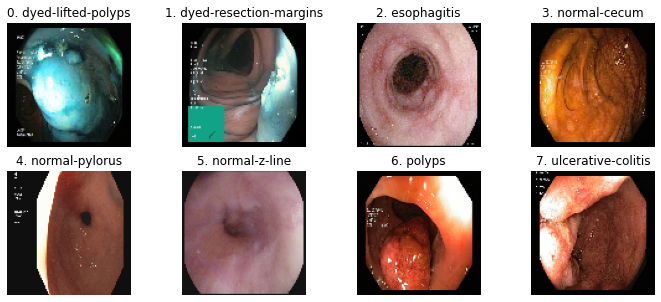

In [7]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()


## **2. Model creation and learning**

### **2.1. Create the training, testing and validation set**
In this step we create:
- the `x_train`/`y_taine` training set
- the `x_test`/`y_test` test set
- the `x_val`/`y_va` validation set

#### **2.1.1. The set of training `(X/y)train` and test `(X/y)test`**
We divide the data (X, y) into training and testing sets using 80% of the data for training and the remaining 20% for testing.

In [8]:
# en convertie y en format scaler
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    x, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


#### **2.1.2. Create validation set `x_val/y_val`**

Here we divide 30% of the training set into a validation set

In [9]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")


x_train:(2240, 100, 100, 3),  y_train:(2240, 1)
x_train:(960, 100, 100, 3),  y_train:(960, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


#### **2.1.3. OneHot Encoding**

We have to do a OneHot Encoding with `to_categorical`, to transform all the lables (`y_train`, `y_val` and `y_test`) so as to have a vector for each example, because we have 8 classes and we should expect the shape of (`y_train`, `y_val` and `y_test`) to change from 1 to 8

In [10]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 8)
x_train:(960, 100, 100, 3),  y_train:(960, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


### **2.2. Image generation**

Here we will perform the image data augmentation. This is the technique used to increase the size of a training dataset by creating modified versions of images in the dataset. The creation of these modified images is done by randomly rotating these images by any degree between 0 and 360.

First, we'll define individual ImageDataGenerator instances for augmentation, and then scale them to each of the training, testing, and validation datasets.

In [11]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


### **2.3. Download the pre-trained model VGG19**

Now we will instantiate the `VGG19` model which is a pre-trained convolutional neural network as a transfer learning model.

The biggest advantage of this network is that it has been pre-trained on over a million images from the ImageNet database.

A pre-trained network can classify images into thousands of object categories. Because of this advantage, we will apply this model to our dataset which has 8 categories, adding other layers to it.

In [12]:
# if it has already been created and saved --> read the model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    #loadmodel
    base_model = load_model("./saved_model/vgg19_model.h5")

# if it has not already been created --> create the model and save it
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

80134624/80134624 [==============================] - 1s 0us/step


We will now define `VGG19` as a deep learning architecture. For this, it will be defined as a sequential model of Keras with several dense layers.

In [13]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

Now to add more layers we need to see the dimension of our model.

In [14]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


Add dense layers with batch activation and normalization

In [15]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

Verification of the final model

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

### **2.4. Hyperparametering**

Hyperparameters are tunable parameters that allow us to control the model training process. Model performance is highly dependent on hyperparameters.

As we have defined our model, now we need to initialize the necessary hyperparameters to train the model, and then finally, we will compile our model.

In [17]:
""" Initializing the hyperparameters """

# initialize the number of training samples
batch_size = 100

# initialize the number of iterations
epochs = 50

# learning rate
learn_rate = 0.001

# initialize gradient descent
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# initialization of the Adam gradient descent
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# compile the model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

Learning rate reduction decreases the learning rate after a certain number of iterations if the error rate does not change. Here, thanks to this technique, we will monitor the accuracy of the validation and if it stops improving we will reduce the learning rate by 0.01.

In [18]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

### **2.5. Model training**

Now we start training our model.

In [19]:
# if model has already been trained and saved ---> read model
if os.path.isfile("./saved_model/model.h5"):

    # read the model
    model = load_model("./saved_model/model.h5")

    # if model history was saved --> read history
    if os.path.isfile("./saved_model/model_history.npy"):

        # read history
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# if the model has not already been trained --> train the model
else:
    history = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )
    history = history. history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 2.6427 - accuracy: 0.1839

22/22 [==============================] - 35s 823ms/step - loss: 2.6427 - accuracy: 0.1839 - val_loss: 1.9946 - val_accuracy: 0.2052 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 1.8633 - accuracy: 0.2746

22/22 [==============================] - 7s 321ms/step - loss: 1.8633 - accuracy: 0.2746 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.8188 - accuracy: 0.2562

22/22 [==============================] - 7s 325ms/step - loss: 1.8188 - accuracy: 0.2562 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.4638

22/22 [==============================] - 7s 327ms/step - loss: 1.1754 - accuracy: 0.4638 - lr: 0.0010
Epoch 5/50
22/22 [==============================] - ETA: 0s - loss: 1.0432 - accuracy: 0.5107

22/22 [==============================] - 7s 329ms/step - loss: 1.0432 - accuracy: 0.5107 - lr: 0.0010
Epoch 6/50
22/22 [==============================] - ETA: 0s - loss: 1.0122 - accuracy: 0.5210

22/22 [==============================] - 7s 332ms/step - loss: 1.0122 - accuracy: 0.5210 - lr: 0.0010
Epoch 7/50
22/22 [==============================] - ETA: 0s - loss: 0.8555 - accuracy: 0.6049

22/22 [==============================] - 7s 335ms/step - loss: 0.8555 - accuracy: 0.6049 - lr: 0.0010
Epoch 8/50
22/22 [==============================] - ETA: 0s - loss: 0.9042 - accuracy: 0.6147

22/22 [==============================] - 7s 338ms/step - loss: 0.9042 - accuracy: 0.6147 - lr: 0.0010
Epoch 9/50
22/22 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6509

22/22 [==============================] - 7s 340ms/step - loss: 0.7521 - accuracy: 0.6509 - lr: 0.0010
Epoch 10/50
22/22 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.6692

22/22 [==============================] - 8s 343ms/step - loss: 0.7442 - accuracy: 0.6692 - lr: 0.0010
Epoch 11/50
22/22 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.6603

22/22 [==============================] - 8s 346ms/step - loss: 0.7334 - accuracy: 0.6603 - lr: 0.0010
Epoch 12/50
22/22 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7031

22/22 [==============================] - 8s 350ms/step - loss: 0.6696 - accuracy: 0.7031 - lr: 0.0010
Epoch 13/50
22/22 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7286

22/22 [==============================] - 8s 354ms/step - loss: 0.6159 - accuracy: 0.7286 - lr: 0.0010
Epoch 14/50
22/22 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.7585

22/22 [==============================] - 8s 354ms/step - loss: 0.5601 - accuracy: 0.7585 - lr: 0.0010
Epoch 15/50
22/22 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7768

22/22 [==============================] - 8s 352ms/step - loss: 0.5164 - accuracy: 0.7768 - lr: 0.0010
Epoch 16/50
22/22 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8201

22/22 [==============================] - 8s 349ms/step - loss: 0.4541 - accuracy: 0.8201 - lr: 0.0010
Epoch 17/50
22/22 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.7973

22/22 [==============================] - 8s 348ms/step - loss: 0.4943 - accuracy: 0.7973 - lr: 0.0010
Epoch 18/50
22/22 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8344

22/22 [==============================] - 8s 346ms/step - loss: 0.4356 - accuracy: 0.8344 - lr: 0.0010
Epoch 19/50
22/22 [==============================] - ETA: 0s - loss: 0.3489 - accuracy: 0.8683

22/22 [==============================] - 8s 346ms/step - loss: 0.3489 - accuracy: 0.8683 - lr: 0.0010
Epoch 20/50
22/22 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8589

22/22 [==============================] - 8s 346ms/step - loss: 0.3597 - accuracy: 0.8589 - lr: 0.0010
Epoch 21/50
22/22 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8701

22/22 [==============================] - 8s 346ms/step - loss: 0.3366 - accuracy: 0.8701 - lr: 0.0010
Epoch 22/50
22/22 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8969

22/22 [==============================] - 8s 348ms/step - loss: 0.2858 - accuracy: 0.8969 - lr: 0.0010
Epoch 23/50
22/22 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8946

22/22 [==============================] - 8s 349ms/step - loss: 0.2712 - accuracy: 0.8946 - lr: 0.0010
Epoch 24/50
22/22 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9147

22/22 [==============================] - 8s 350ms/step - loss: 0.2325 - accuracy: 0.9147 - lr: 0.0010
Epoch 25/50
22/22 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8737

22/22 [==============================] - 8s 351ms/step - loss: 0.3370 - accuracy: 0.8737 - lr: 0.0010
Epoch 26/50
22/22 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9357

22/22 [==============================] - 8s 351ms/step - loss: 0.1839 - accuracy: 0.9357 - lr: 0.0010
Epoch 27/50
22/22 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9366

22/22 [==============================] - 8s 350ms/step - loss: 0.1556 - accuracy: 0.9366 - lr: 0.0010
Epoch 28/50
22/22 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9571

22/22 [==============================] - 8s 350ms/step - loss: 0.1224 - accuracy: 0.9571 - lr: 0.0010
Epoch 29/50
22/22 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9491

22/22 [==============================] - 8s 349ms/step - loss: 0.1547 - accuracy: 0.9491 - lr: 0.0010
Epoch 30/50
22/22 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9647

22/22 [==============================] - 8s 349ms/step - loss: 0.0873 - accuracy: 0.9647 - lr: 0.0010
Epoch 31/50
22/22 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9558

22/22 [==============================] - 8s 349ms/step - loss: 0.1229 - accuracy: 0.9558 - lr: 0.0010
Epoch 32/50
22/22 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9478

22/22 [==============================] - 8s 349ms/step - loss: 0.1639 - accuracy: 0.9478 - lr: 0.0010
Epoch 33/50
22/22 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9576

22/22 [==============================] - 8s 350ms/step - loss: 0.1171 - accuracy: 0.9576 - lr: 0.0010
Epoch 34/50
22/22 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9679

22/22 [==============================] - 8s 349ms/step - loss: 0.0883 - accuracy: 0.9679 - lr: 0.0010
Epoch 35/50
22/22 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9786

22/22 [==============================] - 8s 349ms/step - loss: 0.0686 - accuracy: 0.9786 - lr: 0.0010
Epoch 36/50
22/22 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9835

22/22 [==============================] - 8s 349ms/step - loss: 0.0521 - accuracy: 0.9835 - lr: 0.0010
Epoch 37/50
22/22 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9696

22/22 [==============================] - 8s 351ms/step - loss: 0.0812 - accuracy: 0.9696 - lr: 0.0010
Epoch 38/50
22/22 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9768

22/22 [==============================] - 8s 350ms/step - loss: 0.0658 - accuracy: 0.9768 - lr: 0.0010
Epoch 39/50
22/22 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9817

22/22 [==============================] - 8s 350ms/step - loss: 0.0544 - accuracy: 0.9817 - lr: 0.0010
Epoch 40/50
22/22 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9795

22/22 [==============================] - 8s 351ms/step - loss: 0.0529 - accuracy: 0.9795 - lr: 0.0010
Epoch 41/50
22/22 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9871

22/22 [==============================] - 8s 351ms/step - loss: 0.0387 - accuracy: 0.9871 - lr: 0.0010
Epoch 42/50
22/22 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9848

22/22 [==============================] - 8s 351ms/step - loss: 0.0392 - accuracy: 0.9848 - lr: 0.0010
Epoch 43/50
22/22 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9862

22/22 [==============================] - 8s 350ms/step - loss: 0.0438 - accuracy: 0.9862 - lr: 0.0010
Epoch 44/50
22/22 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

22/22 [==============================] - 8s 351ms/step - loss: 0.0141 - accuracy: 0.9960 - lr: 0.0010
Epoch 45/50
22/22 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9982

22/22 [==============================] - 8s 351ms/step - loss: 0.0081 - accuracy: 0.9982 - lr: 0.0010
Epoch 46/50
22/22 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9969

22/22 [==============================] - 8s 351ms/step - loss: 0.0104 - accuracy: 0.9969 - lr: 0.0010
Epoch 47/50
22/22 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9987

22/22 [==============================] - 8s 351ms/step - loss: 0.0040 - accuracy: 0.9987 - lr: 0.0010
Epoch 48/50
22/22 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9937

22/22 [==============================] - 8s 352ms/step - loss: 0.0179 - accuracy: 0.9937 - lr: 0.0010
Epoch 49/50
22/22 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9799

22/22 [==============================] - 8s 351ms/step - loss: 0.0626 - accuracy: 0.9799 - lr: 0.0010
Epoch 50/50
22/22 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9857

22/22 [==============================] - 8s 351ms/step - loss: 0.0444 - accuracy: 0.9857 - lr: 0.0010


## **3. Model evaluation**

### **3.1. Assess accuracy on test set**

Evaluate the accuracy as well as the loss of the model on the test set

In [35]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))


Test loss: 0.789
Test accuracy: 0.841


### **3.2. Confusion Matrix**

Finally, we will visualize classification performance on test data using confusion matrices.

In [61]:
"""
    The functions uses displays the confusion matrix
"""

# ------------------------------------------------- ---------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
    displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ------------------------------------------------- ---------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    """
        display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

Predict test set classes

In [62]:
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)


25/25 [==============================] - 1s 46ms/step


Displays the normalized and unnormalized confusion matrix.

We will see the exact number of correct and incorrect classifications using the unnormalized confusion matrix, and then we will see the same in percentage using the normalized confusion matrix.

As can be seen by classifying the images into 8 classes, the model gave a minimum accuracy of 84.1% and a maximum accuracy of 98.57%. We can further refine the training parameters and retrain our model to see any possible scaling in the classification

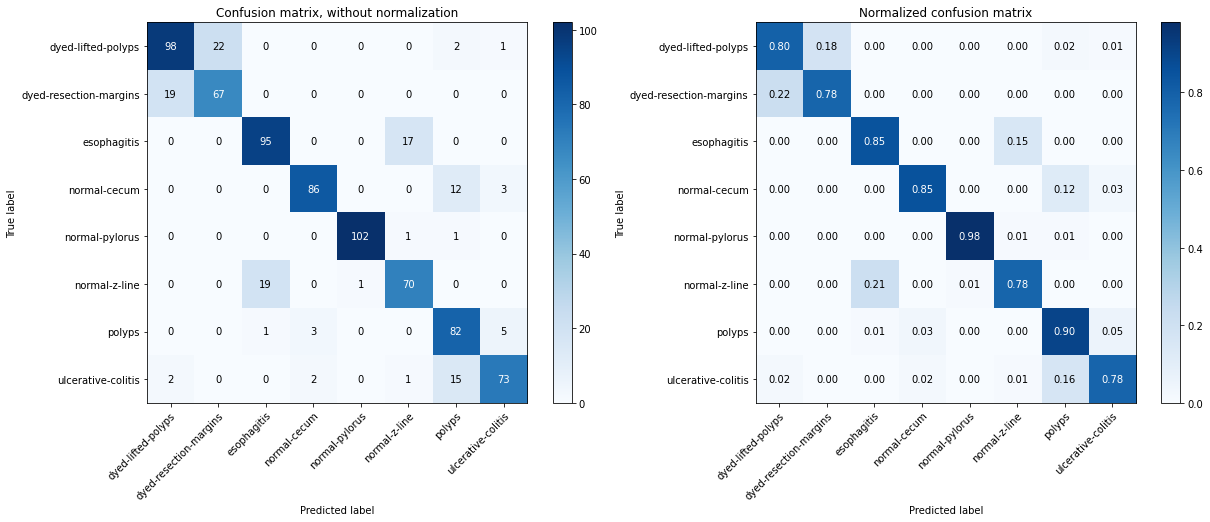

In [63]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

In [67]:
from sklearn.metrics import classification_report

# assume y_true and y_pred are the ground truth and predicted labels, respectively
# and that they are in the same order
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       123
           1       0.75      0.78      0.77        86
           2       0.83      0.85      0.84       112
           3       0.95      0.85      0.90       101
           4       0.99      0.98      0.99       104
           5       0.79      0.78      0.78        90
           6       0.73      0.90      0.81        91
           7       0.89      0.78      0.83        93

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.85      0.84      0.84       800



### **3.3. Random prediction**

Predict randomly chosen images and compare the prediction with the ground truth

1/1 [==============================] - 0s 19ms/step


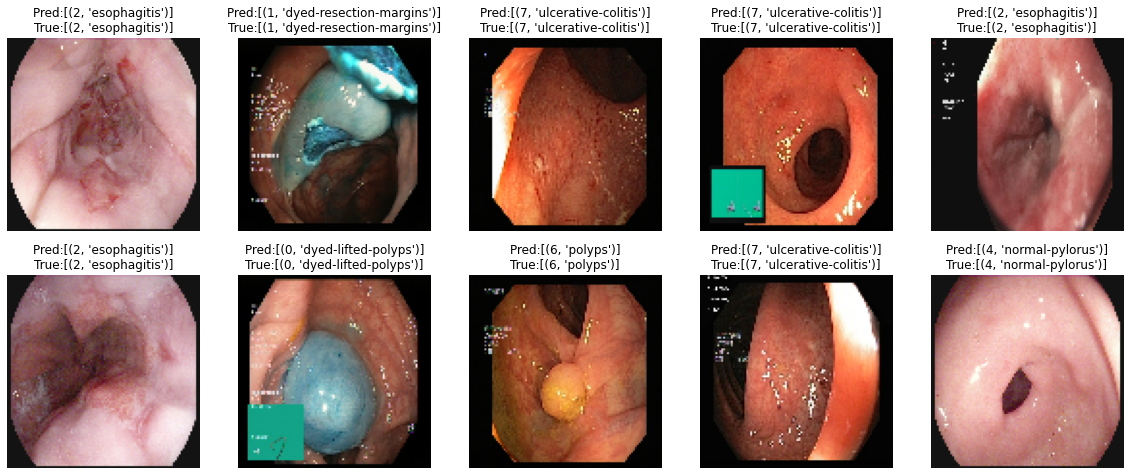

In [64]:
def predict_categorie_img(img, model, categories):
    """
        predict the class of a given image

    args:
        img (numpay): the given image
        model (_type_): the model used for the prediction
        categories (list): list of classes

    Raises:
        TypeError: error if the image is not in RGB (image_dim < 3)

    Returns:
        int: the index of the predie class
        str: the predie class
    """
    try:
        img = img[None,:,:,:]
    except:
        raise TypeError("test image dimension!= 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]

plt. figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = x[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:,:,::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()